<a href="https://colab.research.google.com/github/Chris-Congleton/MSc-Thesis/blob/main/Analysis/2021_SourceClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
!pip install -U gensim
!pip install shap
!pip install datasets

import json, os
import pandas as pd
import numpy as np
import nltk
import glob
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
nltk.download('punkt')

# regular expression library
import re
import pprint

import gensim
from gensim.utils import simple_preprocess
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')

#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction                      
import IPython

from gensim.parsing.preprocessing import preprocess_string
from gensim import utils
import gensim.models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier

import datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 2.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 14.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 14.0 MB/s 
     |████████████████████████████████| 212 kB 60.8 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 63.1 MB/s 
     |████████████████████████████████| 140 kB 57.8 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
     |████████████████████████████████| 596 kB 55.5 MB/s 
     |███████████████████████████

# Loading and cleaning data

In [3]:
path_NRC = 'gdrive/MyDrive/CS/Thesis/Testset_2021/NRC_2021.json'
path_Trouw = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Trouw_2021.json'
path_HetParool = 'gdrive/MyDrive/CS/Thesis/Testset_2021/HetParool_2021.json'
path_Telegraaf = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Telegraaf_2021.json'
path_Volkskrant = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Volkskrant_2021.json'

df_NRC = pd.read_json(path_NRC)
df_Trouw = pd.read_json(path_Trouw)
df_HetParool = pd.read_json(path_HetParool)
df_Telegraaf = pd.read_json(path_Telegraaf)
df_Volkskrant = pd.read_json(path_Volkskrant)

df_NRC["Source"] = "NRC"
df_Trouw["Source"] = "Trouw"
df_HetParool["Source"] = "HetParool"
df_Telegraaf["Source"] = "Telegraaf"
df_Volkskrant["Source"] = "Volkskrant"

## Concat data

In [4]:
dfs = [df_NRC, df_Trouw, df_HetParool, df_Volkskrant]
df = pd.concat(dfs, ignore_index=True)

# Source Classifier

## Preprocessing

In [5]:
# Select only political articles
articles = df.drop(columns=['url', 'publisherID', 'category',], axis=1)
articles = articles[articles['cleantext'].notna()]
# Remove punctuation
articles['cleantext_processed'] = articles['cleantext'].map(lambda x: re.sub('[,\\.!?]', '', x))
# Save D66
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('D66', 'dzeszes', x))
# Save BIJ1
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('BIJ1', 'bijeeen', x))
# Save 50PLUS
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('50PLUS', 'vijfplus', x))
# Save JA21
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('JA21', 'jatweeeen', x))
# Convert the titles to lowercase
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: x.lower())

p_and_p =  ['vvd', 'dzeszes', 'pvv', 'cda', 'pvda', 'sp', 'gl', 'fvd', 'pvdd',
            'cu', 'sgp', 'volt', 'jatweeeen', 'bbb', 'bijeeen', 'vijfplus', 'rutte', 'kaag',
            'wilders', 'hoekstra', 'ploumen', 'marijnissen', 'klaver', 'baudet',
            'ouwehand', 'segers', 'staaij', 'dassen', 'eerdmans', 'plas',
            'simons', 'den haan']

pat = '|'.join(r"\b{}\b".format(x) for x in p_and_p)
articles = articles[articles['cleantext_processed'].str.contains(pat)]
articles = articles[articles['cleantext'].str.len()>5]


In [6]:
# Remove stopwords
stop_words.extend(['nbsp', 'rsquo', 'lsquo','euml', 'rdquo', 'quot', 'ldquo',
                    'we', 'wel', 'jaar', 'zegt', 'gaat','moeten', 'volgens',
                    'heel', 'maken', 'weer', 'gaan', 'twee', 'mensen', 'waar', 'alleen',
                    'komt', 'zoals', 'alle', 'wij', 'zei','komen','tussen', 'eerste','zien'
                    'eigen', 'leven','grote', 'nieuwe','mee','goed', 'aantal','laten'
                    ,'tweede', 'af', 'eerder', 'eigen', 'elkaar','afgelopen', 'week',
                    'zeggen', 'echt', 'dag', 'zien', 'steeds', 'laten', 'willen', 'waarin',
                   'duizend','voormalig', 'nu', 'we'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
            if word not in stop_words] for doc in texts]

articles['cleantext_processed'] = remove_stopwords(articles['cleantext_processed'])

articles['cleantext_processed'] = [' '.join(map(str, l)) for l in articles['cleantext_processed']]

In [7]:
Xy = articles.drop(columns=['timestamp', 'title'])
X = Xy['cleantext_processed']
y = Xy['Source']

# Train test split

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
print(X_train.shape)

(12398,)


In [10]:
print(X_test.shape)

(3100,)


# TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(min_df=50)
tfidfconverter.fit(X_train)
X_train = tfidfconverter.transform(X_train).toarray()
X_test = tfidfconverter.transform(X_test).toarray()

In [14]:
print(X_train.shape)

(12398, 8104)


In [26]:
print(pd.DataFrame(X_train).head())

   0     1     2     3     4     5     6     7     8     9     ...  8094  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

   8095  8096  8097  8098      8099      8100  8101  8102  8103  
0   0.0   0.0   0.0   0.0  0.000000  0.000000   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0  0.031332  0.000000   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0  0.023541  0.000000   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0  0.035579  0.091203   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0  0.000000  0.000000   0.0   0.0   0.0  

[5 rows x 8104 columns]


In [15]:
print(X_test.shape)

(3100, 8104)


# Dummy Classifier

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
classifier = DummyClassifier(strategy='uniform')
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))

[[128 131 113 128]
 [300 326 304 342]
 [142 151 132 141]
 [224 185 187 166]]
              precision    recall  f1-score   support

   HetParool       0.16      0.26      0.20       500
         NRC       0.41      0.26      0.32      1272
       Trouw       0.18      0.23      0.20       566
  Volkskrant       0.21      0.22      0.22       762

    accuracy                           0.24      3100
   macro avg       0.24      0.24      0.23      3100
weighted avg       0.28      0.24      0.25      3100

0.24258064516129033
0.23301603477459706


In [ ]:
classifier = DummyClassifier(strategy='most_frequent')
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))

[[   0  500    0    0]
 [   0 1272    0    0]
 [   0  566    0    0]
 [   0  762    0    0]]
              precision    recall  f1-score   support

   HetParool       0.00      0.00      0.00       500
         NRC       0.41      1.00      0.58      1272
       Trouw       0.00      0.00      0.00       566
  Volkskrant       0.00      0.00      0.00       762

    accuracy                           0.41      3100
   macro avg       0.10      0.25      0.15      3100
weighted avg       0.17      0.41      0.24      3100

0.4103225806451613
0.1454711802378774


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Decision Tree Classifier

In [ ]:
classifier = DecisionTreeClassifier(max_depth=4, random_state=17)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))

[[  99  355    0   46]
 [  93 1101    2   76]
 [  48  466    0   52]
 [  72  560    0  130]]
              precision    recall  f1-score   support

   HetParool       0.32      0.20      0.24       500
         NRC       0.44      0.87      0.59      1272
       Trouw       0.00      0.00      0.00       566
  Volkskrant       0.43      0.17      0.24       762

    accuracy                           0.43      3100
   macro avg       0.30      0.31      0.27      3100
weighted avg       0.34      0.43      0.34      3100

0.4290322580645161
0.2685797810702426


In [ ]:
features = list(tfidfconverter.get_feature_names_out())


In [ ]:
from sklearn import tree
text_representation = tree.export_text(classifier, feature_names=features)
print(text_representation)

|--- demissionair <= 0.00
|   |--- nrc <= 0.01
|   |   |--- amsterdam <= 0.03
|   |   |   |--- gewoon <= 0.03
|   |   |   |   |--- class: NRC
|   |   |   |--- gewoon >  0.03
|   |   |   |   |--- class: Volkskrant
|   |   |--- amsterdam >  0.03
|   |   |   |--- amsterdammers <= 0.04
|   |   |   |   |--- class: HetParool
|   |   |   |--- amsterdammers >  0.04
|   |   |   |   |--- class: HetParool
|   |--- nrc >  0.01
|   |   |--- liet <= 0.05
|   |   |   |--- ingericht <= 0.03
|   |   |   |   |--- class: NRC
|   |   |   |--- ingericht >  0.03
|   |   |   |   |--- class: Trouw
|   |   |--- liet >  0.05
|   |   |   |--- enig <= 0.01
|   |   |   |   |--- class: Trouw
|   |   |   |--- enig >  0.01
|   |   |   |   |--- class: HetParool
|--- demissionair >  0.00
|   |--- volksgezondheid <= 0.01
|   |   |--- demissionair <= 0.05
|   |   |   |--- nrc <= 0.00
|   |   |   |   |--- class: NRC
|   |   |   |--- nrc >  0.00
|   |   |   |   |--- class: NRC
|   |   |--- demissionair >  0.05
|   |   |   

# SVM

In [16]:
from sklearn import svm

In [17]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))

[[157 190  52 101]
 [ 52 963  92 165]
 [ 42 222 184 118]
 [ 41 240  87 394]]
              precision    recall  f1-score   support

   HetParool       0.54      0.31      0.40       500
         NRC       0.60      0.76      0.67      1272
       Trouw       0.44      0.33      0.38       566
  Volkskrant       0.51      0.52      0.51       762

    accuracy                           0.55      3100
   macro avg       0.52      0.48      0.49      3100
weighted avg       0.54      0.55      0.53      3100

0.547741935483871
0.4876022215631838


In [36]:
top_twenty = pd.Series(abs(clf.coef_[0]), index=pd.DataFrame(X_train).columns).nlargest(20)

In [42]:
feature_names = tfidfconverter.get_feature_names_out()

In [43]:
feature_names[top_twenty.index]

array(['amsterdam', 'gisteren', 'ingewijde', 'amsterdammers', 'echter',
       'persbureau', 'rotterdam', 'nrc', 'amsterdamse', 'demissionair',
       'vertelt', 'neer', 'volksgezondheid', 'ondertussen', 'enorm',
       'ton', 'anp', 'ingewijden', 'dinsdag', 'meest'], dtype=object)

In [67]:
print(clf.classes_)

['HetParool' 'NRC' 'Trouw' 'Volkskrant']


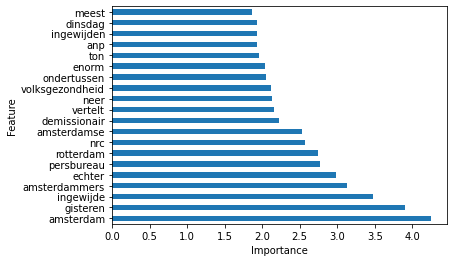

In [64]:
ax = pd.Series(abs(clf.coef_[0]), index=feature_names).nlargest(20).plot(kind='barh')
plt.xlabel("Importance")
plt.ylabel('Feature')
plt.show()

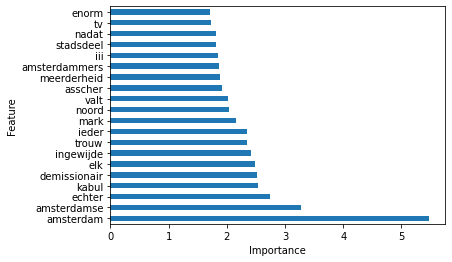

In [63]:
ax = pd.Series(abs(clf.coef_[1]), index=feature_names).nlargest(20).plot(kind='barh')
plt.xlabel("Importance")
plt.ylabel('Feature')
plt.show()

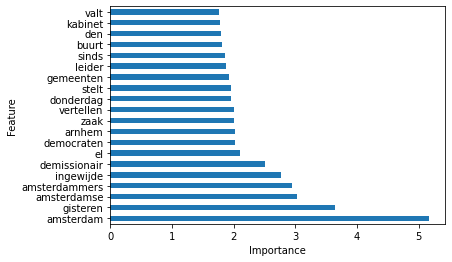

In [65]:
ax = pd.Series(abs(clf.coef_[2]), index=feature_names).nlargest(20).plot(kind='barh')
plt.xlabel("Importance")
plt.ylabel('Feature')
plt.show()

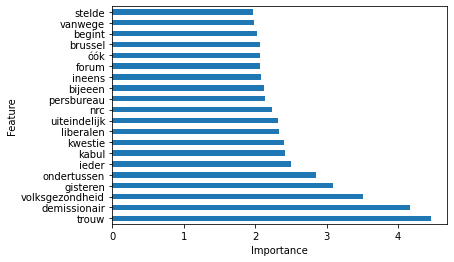

In [66]:
ax = pd.Series(abs(clf.coef_[3]), index=feature_names).nlargest(20).plot(kind='barh')
plt.xlabel("Importance")
plt.ylabel('Feature')
plt.show()

# xgboost


In [ ]:
import xgboost
model = xgboost.XGBClassifier().fit(X_train, y_train)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))

[[ 119  270   16   95]
 [  35 1083   28  126]
 [  23  365   90   88]
 [  28  416   29  289]]
              precision    recall  f1-score   support

   HetParool       0.58      0.24      0.34       500
         NRC       0.51      0.85      0.64      1272
       Trouw       0.55      0.16      0.25       566
  Volkskrant       0.48      0.38      0.43       762

    accuracy                           0.51      3100
   macro avg       0.53      0.41      0.41      3100
weighted avg       0.52      0.51      0.46      3100

0.51
0.4113597038076628


# KNeighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))

[[176 237  28  59]
 [219 872  64 117]
 [138 254  79  95]
 [167 347  60 188]]
              precision    recall  f1-score   support

   HetParool       0.25      0.35      0.29       500
         NRC       0.51      0.69      0.58      1272
       Trouw       0.34      0.14      0.20       566
  Volkskrant       0.41      0.25      0.31       762

    accuracy                           0.42      3100
   macro avg       0.38      0.36      0.35      3100
weighted avg       0.41      0.42      0.40      3100

0.4241935483870968
0.3460908604337307


# Naïve Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))

[[179 100  89 132]
 [210 562 209 291]
 [ 99  97 191 179]
 [112 137 194 319]]
              precision    recall  f1-score   support

   HetParool       0.30      0.36      0.33       500
         NRC       0.63      0.44      0.52      1272
       Trouw       0.28      0.34      0.31       566
  Volkskrant       0.35      0.42      0.38       762

    accuracy                           0.40      3100
   macro avg       0.39      0.39      0.38      3100
weighted avg       0.44      0.40      0.41      3100

0.4035483870967742
0.3822085932543111


In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))

[[  34  303   17  146]
 [   8 1012   21  231]
 [   5  338   55  168]
 [   6  371   28  357]]
              precision    recall  f1-score   support

   HetParool       0.64      0.07      0.12       500
         NRC       0.50      0.80      0.61      1272
       Trouw       0.45      0.10      0.16       566
  Volkskrant       0.40      0.47      0.43       762

    accuracy                           0.47      3100
   macro avg       0.50      0.36      0.33      3100
weighted avg       0.49      0.47      0.41      3100

0.4703225806451613
0.33156157466087255


# Linear SVC

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
clf = LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))

[[173 148  74 105]
 [ 83 891 126 172]
 [ 58 179 206 123]
 [ 60 218 117 367]]
              precision    recall  f1-score   support

   HetParool       0.46      0.35      0.40       500
         NRC       0.62      0.70      0.66      1272
       Trouw       0.39      0.36      0.38       566
  Volkskrant       0.48      0.48      0.48       762

    accuracy                           0.53      3100
   macro avg       0.49      0.47      0.48      3100
weighted avg       0.52      0.53      0.52      3100

0.5280645161290323
0.47807807304369143


# SGD

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
clf = SGDClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))

[[ 154  201   58   87]
 [  45 1039   74  114]
 [  29  262  178   97]
 [  39  293   86  344]]
              precision    recall  f1-score   support

   HetParool       0.58      0.31      0.40       500
         NRC       0.58      0.82      0.68      1272
       Trouw       0.45      0.31      0.37       566
  Volkskrant       0.54      0.45      0.49       762

    accuracy                           0.55      3100
   macro avg       0.54      0.47      0.48      3100
weighted avg       0.54      0.55      0.53      3100

0.5532258064516129
0.4847976119466506


In [ ]:
corpus = list(articles["cleantext_processed"].values)
corp_length = len(corpus)

print("Frame shape: ", articles.shape)
print("Corpus length: ", len(corpus))

class Corpus():
  """An iterator that yields sentences (lists of str)."""

  def __init__(self, corpus):
    self.corpus = corpus

  def __iter__(self):
      for line in self.corpus:
          # assume there's one document per line, tokens separated by whitespace
          yield utils.simple_preprocess(line)

# Training full corpus 60 hours
sentences = Corpus(corpus)
model = gensim.models.Word2Vec(sentences=tqdm(sentences, total=corp_length))

Frame shape:  (15498, 5)
Corpus length:  15498


100%|██████████| 15498/15498 [00:07<00:00, 2006.34it/s]


# RobBert

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 11.4 MB/s 
     |████████████████████████████████| 895 kB 44.5 MB/s 
     |████████████████████████████████| 6.5 MB 43.8 MB/s 
     |████████████████████████████████| 596 kB 46.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")

Downloading:   0%|          | 0.00/715k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/374k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/660 [00:00<?, ?B/s]

In [ ]:
articles = df.drop(columns=['url', 'publisherID', 'category','timestamp', 'title'], axis=1)
articles = articles[articles['cleantext'].str.len()>5]
df_bert = articles

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['cleantext'], truncation=True, padding=True, max_length=128)

In [ ]:
bert_dataset = datasets.Dataset.from_pandas(df_bert)

In [ ]:
bert_dataset = bert_dataset.train_test_split(test_size=0.2)

In [ ]:
tokenized = bert_dataset.map(preprocess_function, batched=True)

  0%|          | 0/78 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

In [ ]:
tokenized = tokenized.class_encode_column("Source")

Casting to class labels:   0%|          | 0/78 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/20 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
model = RobertaForSequenceClassification.from_pretrained("pdelobelle/robbert-v2-dutch-base", num_labels=4)

Downloading:   0%|          | 0.00/446M [00:00<?, ?B/s]

Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.out_proj.bias', 'clas

In [ ]:
tokenized = tokenized.rename_column("Source", "label")

In [ ]:
!pip install wandb

import wandb
wandb.login()

     |████████████████████████████████| 1.8 MB 12.3 MB/s 
     |████████████████████████████████| 181 kB 54.3 MB/s 
     |████████████████████████████████| 144 kB 46.8 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=31dcad12c6713741780f9a38bbd01e3aed542bf61c54d5cee9dc5bfe10928514
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
%env WANDB_PROJECT=source_classification

env: WANDB_PROJECT=source_classification


In [ ]:
from datasets import load_metric

In [ ]:
def compute_metrics(eval_pred):
    metric1 = load_metric("precision")
    metric2 = load_metric("recall")
    metric3 = load_metric("f1")
    metric4 = load_metric("accuracy")
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = metric1.compute(predictions=predictions, references=labels, average="macro")["precision"]
    recall = metric2.compute(predictions=predictions, references=labels, average="macro")["recall"]
    f1 = metric3.compute(predictions=predictions, references=labels, average="macro")["f1"]
    accuracy = metric4.compute(predictions=predictions, references=labels)["accuracy"]

    return {"precision": precision, "recall": recall, "f1":f1, "accuracy":accuracy}

In [ ]:
training_args = TrainingArguments(

    output_dir="./results",

    learning_rate=1e-5,

    per_device_train_batch_size=16,

    per_device_eval_batch_size=16,

    num_train_epochs=3,

    weight_decay=0.01,

    report_to="wandb",

    evaluation_strategy = "steps",

    logging_steps = 100,                    # we will log every 100 steps
    eval_steps = 1000,                      # we will perform evaluation every 1000 steps
    save_steps = 5000,
    load_best_model_at_end = True,

)

trainer = Trainer(

    model=model,

    args=training_args,

    train_dataset=tokenized['train'],

    eval_dataset=tokenized['test'],

    tokenizer=tokenizer,

    data_collator=data_collator,

    compute_metrics=compute_metrics,

)

trainer.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: cleantext, __index_level_0__. If cleantext, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 77472
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 14526
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


wandb: Currently logged in as: chriscongleton (use `wandb login --relogin` to force relogin)


Step,Training Loss,Validation Loss


In [ ]:
wandb.finish()